In [1]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchmetrics.segmentation import MeanIoU

if torch.cuda.is_available():
    device = torch.device("cuda")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


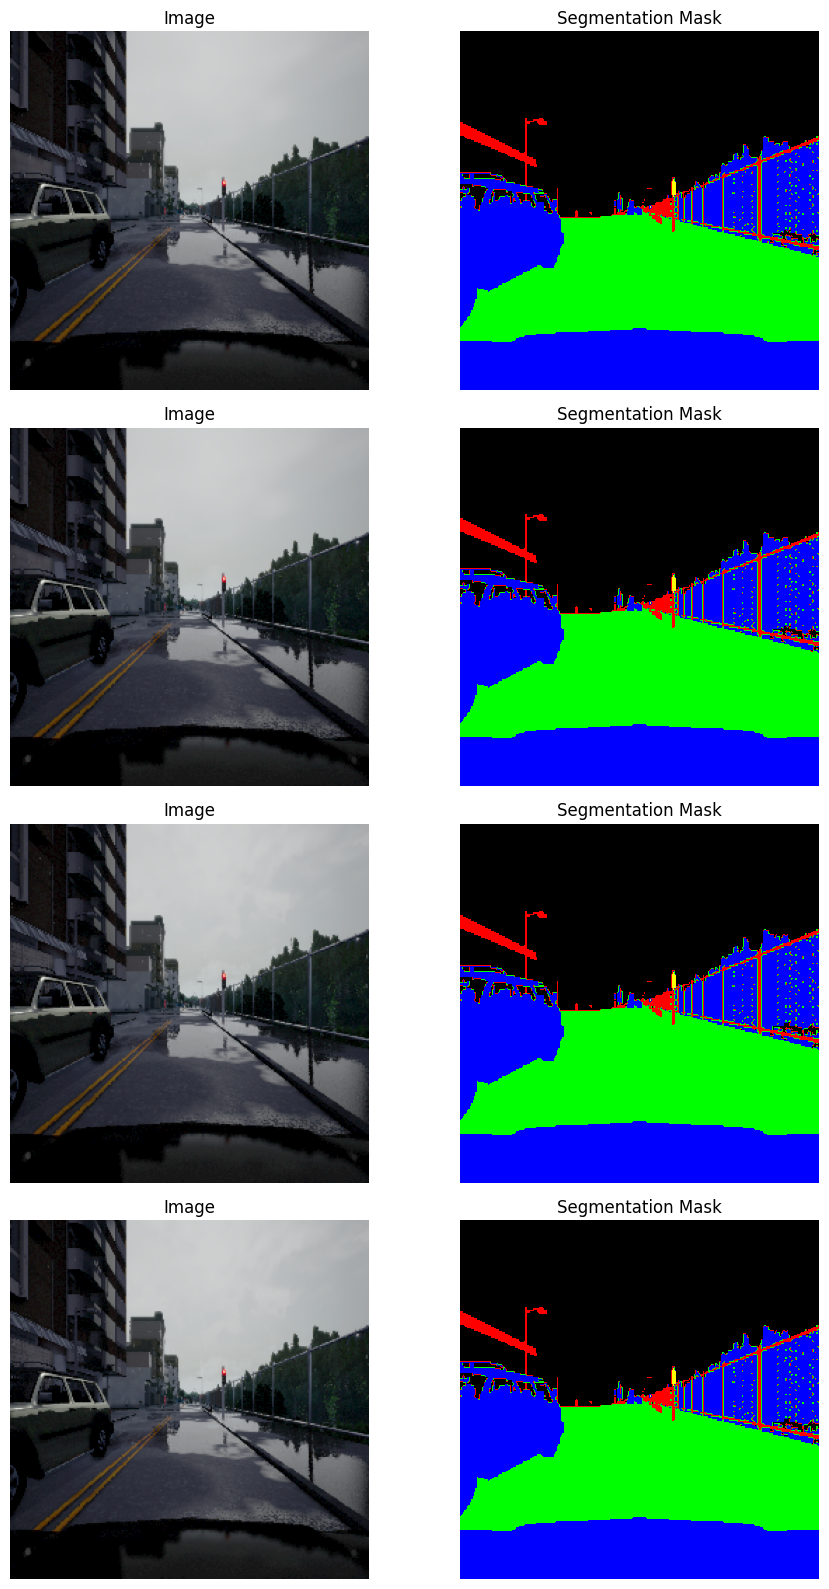

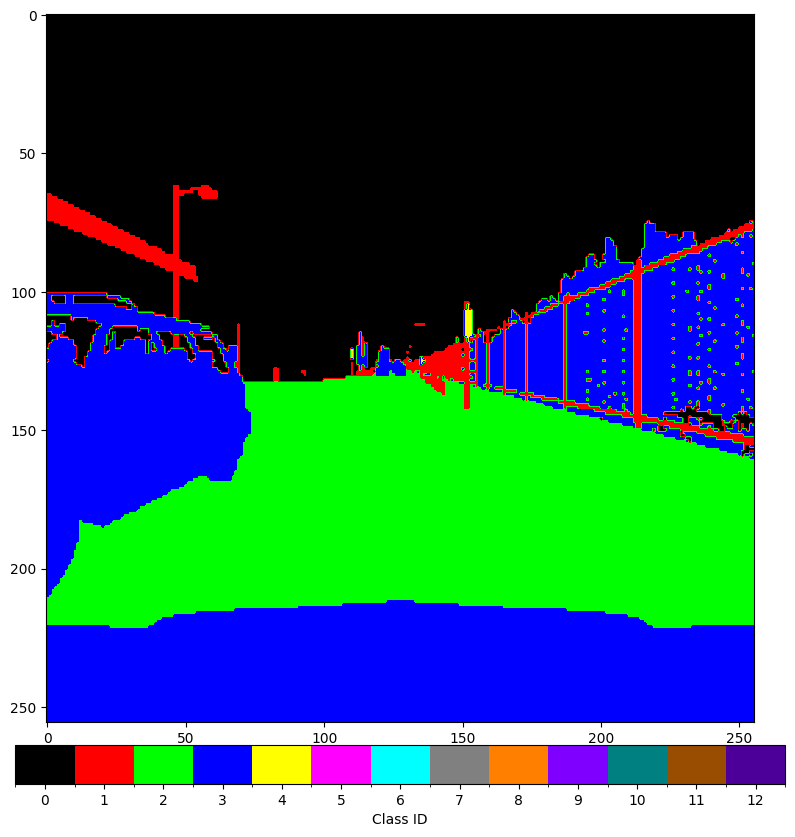

In [ ]:
DATASET_PATH = "../dataset_256"
TRAIN_IMAGES_DIR = os.path.join(DATASET_PATH, "train/images")
TRAIN_LABELS_DIR = os.path.join(DATASET_PATH, "train/labels")

def load_image(path):
    return Image.open(path).convert('RGB')

def load_mask(path):
    return Image.open(path).convert('L')   

# Define a colormap for 13 classes 0 to 12
colors = [
    (0.0, 0.0, 0.0),      # class 0 - black
    (1.0, 0.0, 0.0),      # class 1 - red
    (0.0, 1.0, 0.0),      # class 2 - green
    (0.0, 0.0, 1.0),      # class 3 - blue
    (1.0, 1.0, 0.0),      # class 4 - yellow
    (1.0, 0.0, 1.0),      # class 5 - magenta
    (0.0, 1.0, 1.0),      # class 6 - cyan
    (0.5, 0.5, 0.5),      # class 7 - gray
    (1.0, 0.5, 0.0),      # class 8 - orange
    (0.5, 0.0, 1.0),      # class 9 - purple
    (0.0, 0.5, 0.5),      # class 10 - teal
    (0.6, 0.3, 0.0),      # class 11 - brown
    (0.3, 0.0, 0.6),      # class 12 - indigo
]
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries=np.arange(14) - 0.5, ncolors=13)
image_files = sorted([os.path.join(TRAIN_IMAGES_DIR, f) for f in os.listdir(TRAIN_IMAGES_DIR) if f.endswith('.png')])
label_files = sorted([os.path.join(TRAIN_LABELS_DIR, f) for f in os.listdir(TRAIN_LABELS_DIR) if f.endswith('.png')])
num_samples_to_display = 4
plt.figure(figsize=(10, num_samples_to_display * 4))

# display the first num_samples_to_display images and their segmentation masks
for i in range(num_samples_to_display):
    img = load_image(image_files[i])
    mask = np.array(load_mask(label_files[i]))   
    plt.subplot(num_samples_to_display, 2, i * 2 + 1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis("off")
    plt.subplot(num_samples_to_display, 2, i * 2 + 2)
    im = plt.imshow(mask, cmap=cmap, norm=norm)
    plt.title("Segmentation Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
mask = np.array(load_mask(label_files[0]))
im = plt.imshow(mask, cmap=cmap, norm=norm)
cbar = plt.colorbar(im, ax=plt.gcf().get_axes(), orientation='horizontal', fraction=0.05, pad=0.03)
cbar.set_ticks(np.arange(13))
cbar.set_label("Class ID")
plt.show()

TEST_IMAGES_DIR = os.path.join(DATASET_PATH, "test/images")
TEST_LABELS_DIR = os.path.join(DATASET_PATH, "test/labels")

In [ ]:
def is_image_file(filename):
    return filename.endswith(('.png'))

class SegmentationDataset(Dataset):
    # class to load and pre-process (transfprm) the dataset 
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted([f for f in os.listdir(image_dir) if is_image_file(f)])
        self.masks = sorted([f for f in os.listdir(mask_dir) if is_image_file(f)])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        try:
            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")
        except UnidentifiedImageError as e:
            raise RuntimeError(f"Could not load image or mask: {img_path}, {mask_path}") from e
        image = image.resize((256, 256))
        mask = mask.resize((256, 256), resample=Image.NEAREST)
        if self.transform:
            image = self.transform(image)
        mask = torch.tensor(np.array(mask), dtype=torch.long)
        return image, mask

In [4]:
EPOCHS = 50
BATCH_SIZE = 20
LR = 1e-4


DATASET_PATH = "../dataset_256"
full_dataset = SegmentationDataset(
    os.path.join(DATASET_PATH, "train/images"),
    os.path.join(DATASET_PATH, "train/labels"),
    transform=transforms.ToTensor()
)
test_dataset = SegmentationDataset(
    os.path.join(DATASET_PATH, "test/images"),
    os.path.join(DATASET_PATH, "test/labels"),
    transform=transforms.ToTensor()
)

indices = list(range(len(full_dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.25, random_state=42)

train_loader = DataLoader(Subset(full_dataset, train_idx), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(Subset(full_dataset, val_idx), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
def visualize_prediction(image, mask, pred):
    # visualize the input image, ground truth mask, and model prediction
    image = image.permute(1, 2, 0).cpu().numpy()
    mask = mask.cpu().numpy()
    pred = pred.cpu().numpy()
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Input")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='nipy_spectral', vmin=0, vmax=12)
    plt.title("Ground Truth")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap='nipy_spectral', vmin=0, vmax=12)
    plt.title("Prediction")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Vanilla U-Net

In [ ]:
class DoubleConv(nn.Module):
    # class to define a double convolution block
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    # class to define the UNet model, with 4 down-sampling and 4 up-sampling from the image
    def __init__(self, in_channels=3, out_classes=13):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        self.final = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b = self.bottleneck(self.pool4(e4))
        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.final(d1)

Epoch 1/50: 100%|██████████| 75/75 [00:44<00:00,  1.69it/s]


Epoch 1: Loss=1.7969, Val mIoU=0.4856


Epoch 2/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 2: Loss=0.8075, Val mIoU=0.6055


Epoch 3/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 3: Loss=0.5844, Val mIoU=0.5881


Epoch 4/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 4: Loss=0.3747, Val mIoU=0.6334


Epoch 5/50: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]


Epoch 5: Loss=0.3164, Val mIoU=0.6122


Epoch 6/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 6: Loss=0.7993, Val mIoU=0.6358


Epoch 7/50: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]


Epoch 7: Loss=0.7047, Val mIoU=0.6429


Epoch 8/50: 100%|██████████| 75/75 [00:40<00:00,  1.87it/s]


Epoch 8: Loss=0.6751, Val mIoU=0.5136


Epoch 9/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 9: Loss=0.8247, Val mIoU=0.6424


Epoch 10/50: 100%|██████████| 75/75 [00:40<00:00,  1.87it/s]


Epoch 10: Loss=0.6545, Val mIoU=0.6399


Epoch 11/50: 100%|██████████| 75/75 [00:40<00:00,  1.87it/s]


Epoch 11: Loss=0.6224, Val mIoU=0.6348


Epoch 12/50: 100%|██████████| 75/75 [00:40<00:00,  1.87it/s]


Epoch 12: Loss=0.5939, Val mIoU=0.6586


Epoch 13/50: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]


Epoch 13: Loss=0.4674, Val mIoU=0.6892


Epoch 14/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 14: Loss=0.3784, Val mIoU=0.6978


Epoch 15/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 15: Loss=0.2909, Val mIoU=0.7224


Epoch 16/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 16: Loss=0.2424, Val mIoU=0.7375


Epoch 17/50: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]


Epoch 17: Loss=0.2068, Val mIoU=0.7473


Epoch 18/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 18: Loss=0.1849, Val mIoU=0.7545


Epoch 19/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 19: Loss=0.1844, Val mIoU=0.7658


Epoch 20/50: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]


Epoch 20: Loss=0.1544, Val mIoU=0.7687


Epoch 21/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 21: Loss=0.1410, Val mIoU=0.7793


Epoch 22/50: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]


Epoch 22: Loss=0.1309, Val mIoU=0.7933


Epoch 23/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 23: Loss=0.1221, Val mIoU=0.7945


Epoch 24/50: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]


Epoch 24: Loss=0.1174, Val mIoU=0.7993


Epoch 25/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 25: Loss=0.1123, Val mIoU=0.8000


Epoch 26/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 26: Loss=0.1027, Val mIoU=0.8095


Epoch 27/50: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]


Epoch 27: Loss=0.0965, Val mIoU=0.8120


Epoch 28/50: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]


Epoch 28: Loss=0.0957, Val mIoU=0.8124


Epoch 29/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 29: Loss=0.0908, Val mIoU=0.8189


Epoch 30/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 30: Loss=0.0850, Val mIoU=0.8203


Epoch 31/50: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]


Epoch 31: Loss=0.0829, Val mIoU=0.8212


Epoch 32/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 32: Loss=0.0804, Val mIoU=0.8228


Epoch 33/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 33: Loss=0.0772, Val mIoU=0.8235


Epoch 34/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 34: Loss=0.0738, Val mIoU=0.8268


Epoch 35/50: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]


Epoch 35: Loss=0.0712, Val mIoU=0.8274


Epoch 36/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 36: Loss=0.0697, Val mIoU=0.8283


Epoch 37/50: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]


Epoch 37: Loss=0.0691, Val mIoU=0.8296


Epoch 38/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 38: Loss=0.0673, Val mIoU=0.8304


Epoch 39/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 39: Loss=0.0680, Val mIoU=0.8285


Epoch 40/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 40: Loss=0.0649, Val mIoU=0.8334


Epoch 41/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 41: Loss=0.0614, Val mIoU=0.8341


Epoch 42/50: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]


Epoch 42: Loss=0.0605, Val mIoU=0.8343


Epoch 43/50: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]


Epoch 43: Loss=0.0590, Val mIoU=0.8360


Epoch 44/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 44: Loss=0.0578, Val mIoU=0.8362


Epoch 45/50: 100%|██████████| 75/75 [00:40<00:00,  1.87it/s]


Epoch 45: Loss=0.0577, Val mIoU=0.8356


Epoch 46/50: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]


Epoch 46: Loss=0.0578, Val mIoU=0.8348


Epoch 47/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 47: Loss=0.0567, Val mIoU=0.8375


Epoch 48/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 48: Loss=0.0557, Val mIoU=0.8389


Epoch 49/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 49: Loss=0.0547, Val mIoU=0.8383


Epoch 50/50: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 50: Loss=0.0531, Val mIoU=0.8391


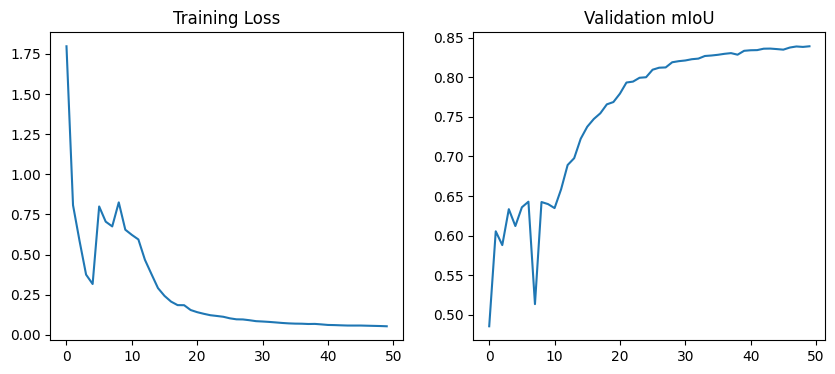

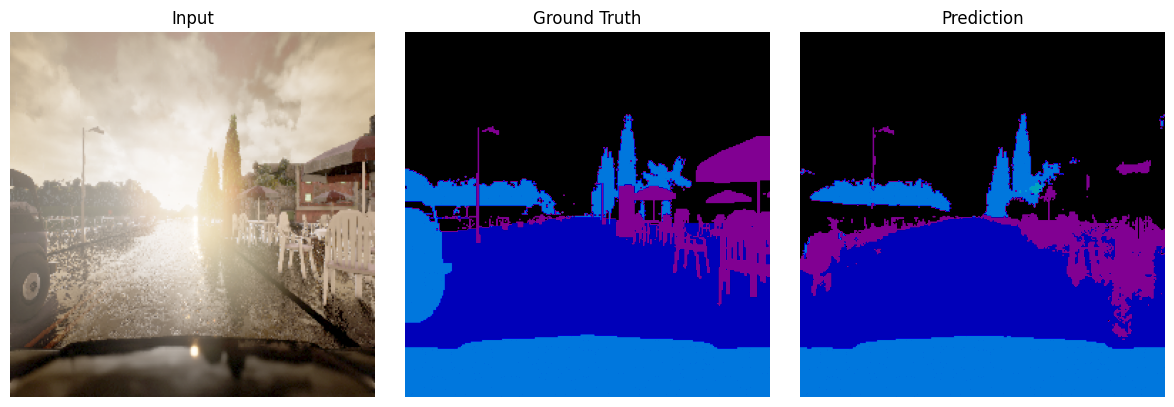

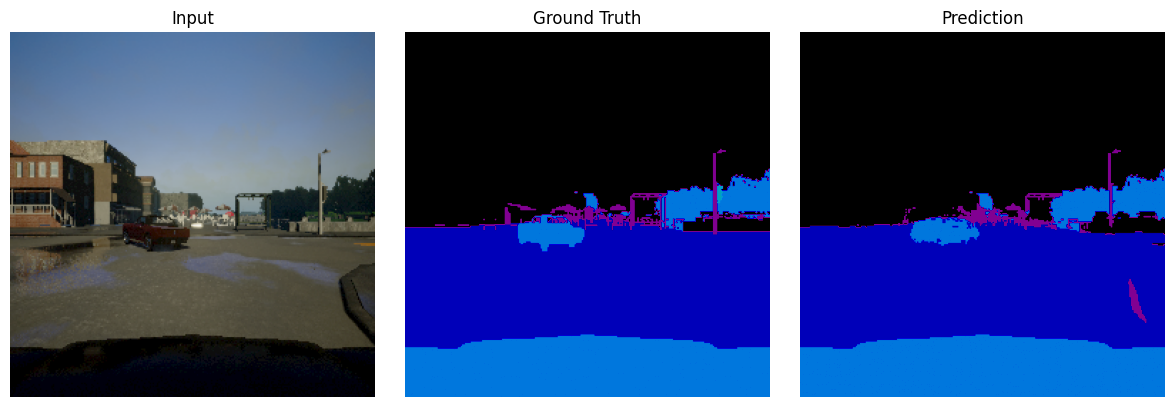

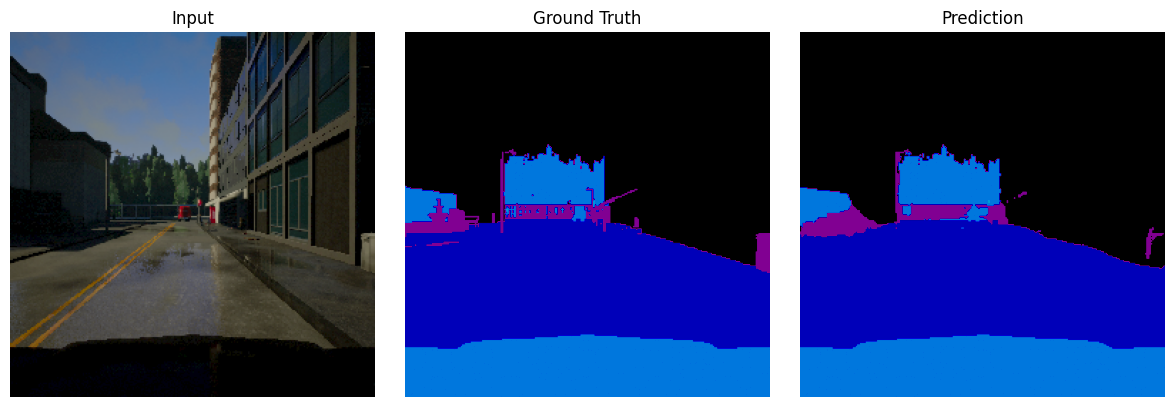

Test mIoU: 0.8320


In [ ]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_mious = []

for epoch in range(EPOCHS):
    # train the model, compute the training loss, mIoU
    model.train()
    epoch_loss = 0
    train_metric = MeanIoU(num_classes=13).to(device)
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_metric.update(preds, masks)
    train_losses.append(epoch_loss / len(train_loader))

    # Validation mIoU
    model.eval()
    val_metric = MeanIoU(num_classes=13).to(device)
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            val_metric.update(preds, masks)
    val_miou = val_metric.compute().item()
    val_mious.append(val_miou)
    print(f"Epoch {epoch+1}: Loss={train_losses[-1]:.4f}, Val mIoU={val_miou:.4f}")

# plot the training loss and validation mIoU
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Loss")
plt.title("Training Loss")
plt.subplot(1, 2, 2)
plt.plot(val_mious, label="Val mIoU")
plt.title("Validation mIoU")
plt.show()

# Visualize predictions
model.eval()
with torch.no_grad():
    for i, (img, msk) in enumerate(val_loader):
        if i == 3: break
        img, msk = img.to(device), msk.to(device)
        out = model(img)
        pred = torch.argmax(out, dim=1)
        visualize_prediction(img[0], msk[0], pred[0])

# Test mIoU
model.eval()
test_metric = MeanIoU(num_classes=13).to(device)
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        test_metric.update(preds, masks)

test_miou = test_metric.compute().item()
print(f"Test mIoU: {test_miou:.4f}")

# U-Net without Skip

In [ ]:
class UNet_NoSkip(nn.Module):
    # class with no skip connections adapted from the UNet model
    def __init__(self, in_channels=3, out_classes=13):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(512, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(256, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(128, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(64, 64)
        self.final = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b = self.bottleneck(self.pool4(e4))
        d4 = self.dec4(self.up4(b))
        d3 = self.dec3(self.up3(d4))
        d2 = self.dec2(self.up2(d3))
        d1 = self.dec1(self.up1(d2))
        return self.final(d1)

[NoSkip] Epoch 1/50: 100%|██████████| 150/150 [00:37<00:00,  3.97it/s]


[NoSkip] Epoch 1: Loss=1.4213, Val mIoU=0.1748


[NoSkip] Epoch 2/50: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s]


[NoSkip] Epoch 2: Loss=0.7746, Val mIoU=0.5482


[NoSkip] Epoch 3/50: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s]


[NoSkip] Epoch 3: Loss=0.4334, Val mIoU=0.5997


[NoSkip] Epoch 4/50: 100%|██████████| 150/150 [00:36<00:00,  4.08it/s]


[NoSkip] Epoch 4: Loss=0.3547, Val mIoU=0.6573


[NoSkip] Epoch 5/50: 100%|██████████| 150/150 [00:36<00:00,  4.08it/s]


[NoSkip] Epoch 5: Loss=0.3136, Val mIoU=0.6663


[NoSkip] Epoch 6/50: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s]


[NoSkip] Epoch 6: Loss=0.2831, Val mIoU=0.6700


[NoSkip] Epoch 7/50: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s]


[NoSkip] Epoch 7: Loss=0.2683, Val mIoU=0.6739


[NoSkip] Epoch 8/50: 100%|██████████| 150/150 [00:36<00:00,  4.07it/s]


[NoSkip] Epoch 8: Loss=0.2517, Val mIoU=0.6968


[NoSkip] Epoch 9/50: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s]


[NoSkip] Epoch 9: Loss=0.2402, Val mIoU=0.6567


[NoSkip] Epoch 10/50: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s]


[NoSkip] Epoch 10: Loss=0.2310, Val mIoU=0.6923


[NoSkip] Epoch 11/50: 100%|██████████| 150/150 [00:36<00:00,  4.06it/s]


[NoSkip] Epoch 11: Loss=0.2203, Val mIoU=0.7104


[NoSkip] Epoch 12/50: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s]


[NoSkip] Epoch 12: Loss=0.2128, Val mIoU=0.7136


[NoSkip] Epoch 13/50: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s]


[NoSkip] Epoch 13: Loss=0.2053, Val mIoU=0.7169


[NoSkip] Epoch 14/50: 100%|██████████| 150/150 [00:36<00:00,  4.08it/s]


[NoSkip] Epoch 14: Loss=0.1955, Val mIoU=0.7226


[NoSkip] Epoch 15/50: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s]


[NoSkip] Epoch 15: Loss=0.1904, Val mIoU=0.7231


[NoSkip] Epoch 16/50: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s]


[NoSkip] Epoch 16: Loss=0.1840, Val mIoU=0.7236


[NoSkip] Epoch 17/50: 100%|██████████| 150/150 [00:36<00:00,  4.07it/s]


[NoSkip] Epoch 17: Loss=0.1763, Val mIoU=0.7329


[NoSkip] Epoch 18/50: 100%|██████████| 150/150 [00:36<00:00,  4.07it/s]


[NoSkip] Epoch 18: Loss=0.1701, Val mIoU=0.7361


[NoSkip] Epoch 19/50: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s]


[NoSkip] Epoch 19: Loss=0.1638, Val mIoU=0.7324


[NoSkip] Epoch 20/50: 100%|██████████| 150/150 [00:36<00:00,  4.08it/s]


[NoSkip] Epoch 20: Loss=0.1621, Val mIoU=0.7347


[NoSkip] Epoch 21/50: 100%|██████████| 150/150 [00:36<00:00,  4.07it/s]


[NoSkip] Epoch 21: Loss=0.1557, Val mIoU=0.7403


[NoSkip] Epoch 22/50: 100%|██████████| 150/150 [00:36<00:00,  4.08it/s]


[NoSkip] Epoch 22: Loss=0.1700, Val mIoU=0.7446


[NoSkip] Epoch 23/50: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s]


[NoSkip] Epoch 23: Loss=0.1459, Val mIoU=0.7468


[NoSkip] Epoch 24/50: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s]


[NoSkip] Epoch 24: Loss=0.1416, Val mIoU=0.7466


[NoSkip] Epoch 25/50: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s]


[NoSkip] Epoch 25: Loss=0.1376, Val mIoU=0.7501


[NoSkip] Epoch 26/50: 100%|██████████| 150/150 [00:36<00:00,  4.08it/s]


[NoSkip] Epoch 26: Loss=0.1357, Val mIoU=0.7517


[NoSkip] Epoch 27/50: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s]


[NoSkip] Epoch 27: Loss=0.1315, Val mIoU=0.7567


[NoSkip] Epoch 28/50: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s]


[NoSkip] Epoch 28: Loss=0.1283, Val mIoU=0.7553


[NoSkip] Epoch 29/50: 100%|██████████| 150/150 [00:36<00:00,  4.07it/s]


[NoSkip] Epoch 29: Loss=0.1249, Val mIoU=0.7551


[NoSkip] Epoch 30/50: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s]


[NoSkip] Epoch 30: Loss=0.1238, Val mIoU=0.7584


[NoSkip] Epoch 31/50: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s]


[NoSkip] Epoch 31: Loss=0.1229, Val mIoU=0.7569


[NoSkip] Epoch 32/50: 100%|██████████| 150/150 [00:37<00:00,  4.05it/s]


[NoSkip] Epoch 32: Loss=0.1197, Val mIoU=0.7585


[NoSkip] Epoch 33/50: 100%|██████████| 150/150 [00:36<00:00,  4.08it/s]


[NoSkip] Epoch 33: Loss=0.1159, Val mIoU=0.7616


[NoSkip] Epoch 34/50: 100%|██████████| 150/150 [00:36<00:00,  4.08it/s]


[NoSkip] Epoch 34: Loss=0.1158, Val mIoU=0.7529


[NoSkip] Epoch 35/50: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s]


[NoSkip] Epoch 35: Loss=0.1137, Val mIoU=0.7629


[NoSkip] Epoch 36/50: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s]


[NoSkip] Epoch 36: Loss=0.1118, Val mIoU=0.7550


[NoSkip] Epoch 37/50: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s]


[NoSkip] Epoch 37: Loss=0.8684, Val mIoU=0.4744


[NoSkip] Epoch 38/50: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s]


[NoSkip] Epoch 38: Loss=0.3684, Val mIoU=0.6611


[NoSkip] Epoch 39/50: 100%|██████████| 150/150 [00:36<00:00,  4.11it/s]


[NoSkip] Epoch 39: Loss=0.2943, Val mIoU=0.6780


[NoSkip] Epoch 40/50: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s]


[NoSkip] Epoch 40: Loss=0.2598, Val mIoU=0.6913


[NoSkip] Epoch 41/50: 100%|██████████| 150/150 [00:36<00:00,  4.08it/s]


[NoSkip] Epoch 41: Loss=0.2404, Val mIoU=0.7038


[NoSkip] Epoch 42/50: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s]


[NoSkip] Epoch 42: Loss=0.2231, Val mIoU=0.7064


[NoSkip] Epoch 43/50: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s]


[NoSkip] Epoch 43: Loss=0.2113, Val mIoU=0.7014


[NoSkip] Epoch 44/50: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s]


[NoSkip] Epoch 44: Loss=0.2013, Val mIoU=0.7143


[NoSkip] Epoch 45/50: 100%|██████████| 150/150 [00:36<00:00,  4.11it/s]


[NoSkip] Epoch 45: Loss=0.1929, Val mIoU=0.7235


[NoSkip] Epoch 46/50: 100%|██████████| 150/150 [00:36<00:00,  4.11it/s]


[NoSkip] Epoch 46: Loss=0.1853, Val mIoU=0.7231


[NoSkip] Epoch 47/50: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s]


[NoSkip] Epoch 47: Loss=0.1787, Val mIoU=0.7256


[NoSkip] Epoch 48/50: 100%|██████████| 150/150 [00:36<00:00,  4.11it/s]


[NoSkip] Epoch 48: Loss=0.1710, Val mIoU=0.7298


[NoSkip] Epoch 49/50: 100%|██████████| 150/150 [00:36<00:00,  4.11it/s]


[NoSkip] Epoch 49: Loss=0.1674, Val mIoU=0.7273


[NoSkip] Epoch 50/50: 100%|██████████| 150/150 [00:36<00:00,  4.09it/s]


[NoSkip] Epoch 50: Loss=0.1623, Val mIoU=0.7329


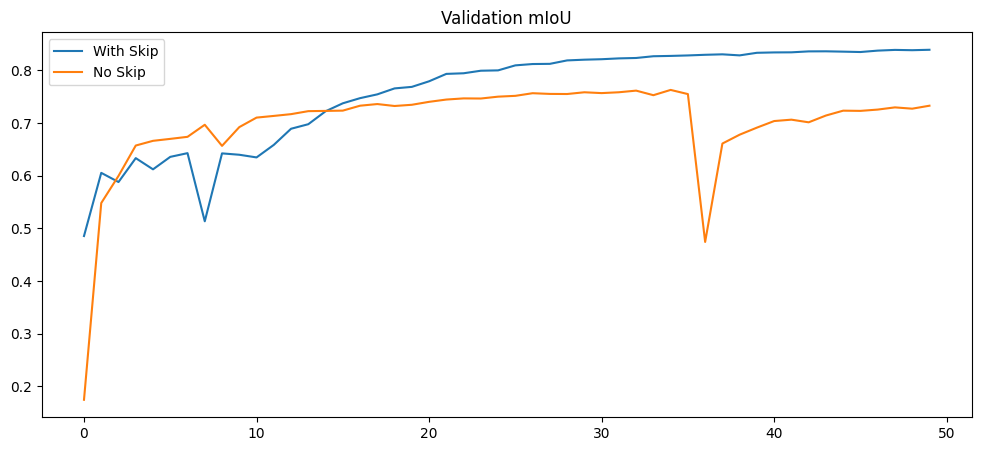

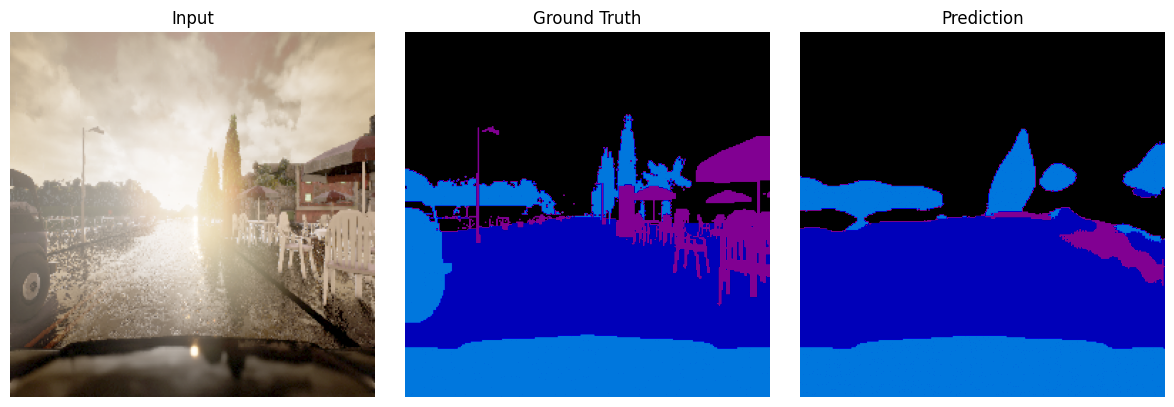

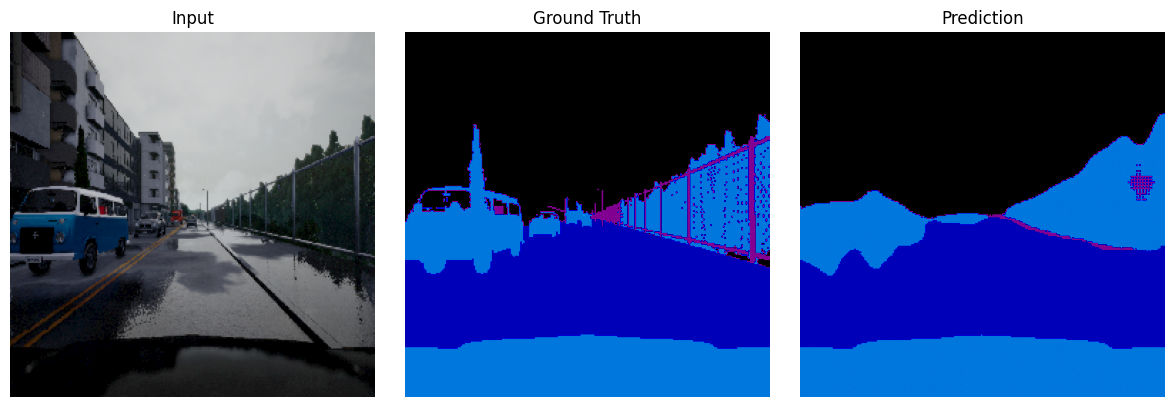

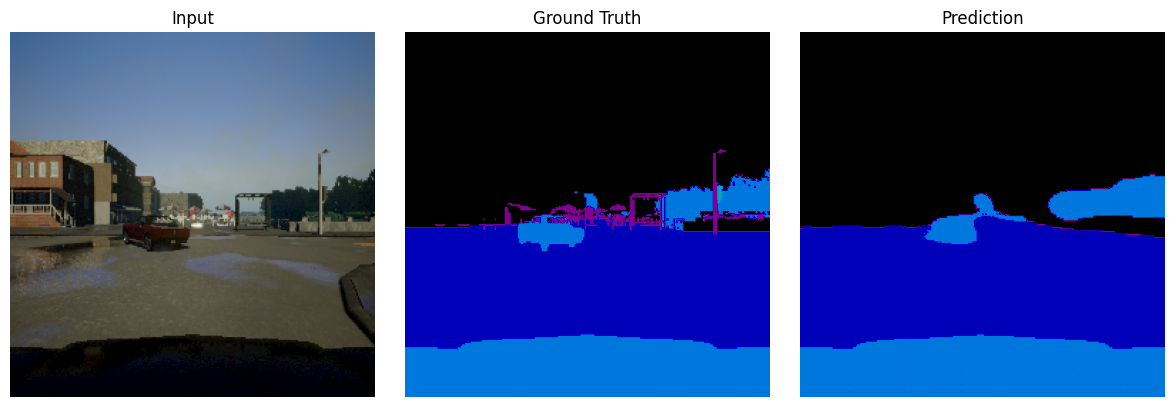

[NoSkip] Test mIoU: 0.7280


In [ ]:
# Train the model with no skip, compute the training loss, mIoU, plot the training loss and validation mIoU
model_noskip = UNet_NoSkip().to(device)
optimizer = torch.optim.Adam(model_noskip.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
train_losses_noskip = []
val_mious_noskip = []
for epoch in range(EPOCHS):
    model_noskip.train()
    epoch_loss = 0
    train_metric = MeanIoU(num_classes=13).to(device)
    for images, masks in tqdm(train_loader, desc=f"[NoSkip] Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model_noskip(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_metric.update(preds, masks)
    train_losses_noskip.append(epoch_loss / len(train_loader))
    model_noskip.eval()
    val_metric = MeanIoU(num_classes=13).to(device)
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model_noskip(images)
            preds = torch.argmax(outputs, dim=1)
            val_metric.update(preds, masks)
    val_miou = val_metric.compute().item()
    val_mious_noskip.append(val_miou)
    print(f"[NoSkip] Epoch {epoch+1}: Loss={train_losses_noskip[-1]:.4f}, Val mIoU={val_miou:.4f}")

plt.figure(figsize=(12, 5))
plt.plot(val_mious, label="With Skip")
plt.plot(val_mious_noskip, label="No Skip")
plt.title("Validation mIoU")
plt.legend()
plt.show()

model_noskip.eval()
with torch.no_grad():
    for i, (img, msk) in enumerate(val_loader):
        if i == 3: break
        img, msk = img.to(device), msk.to(device)
        out = model_noskip(img)
        pred = torch.argmax(out, dim=1)
        visualize_prediction(img[0], msk[0], pred[0])

model_noskip.eval()
test_metric = MeanIoU(num_classes=13).to(device)
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model_noskip(images)
        preds = torch.argmax(outputs, dim=1)
        test_metric.update(preds, masks)

test_miou = test_metric.compute().item()
print(f"[NoSkip] Test mIoU: {test_miou:.4f}")

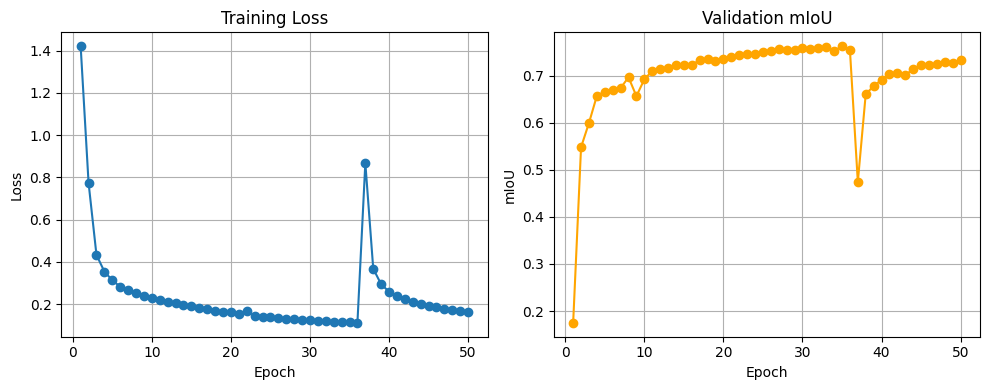

In [ ]:
# plot the training loss and validation mIoU
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses_noskip) + 1), train_losses_noskip, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_mious_noskip) + 1), val_mious_noskip, marker='o', linestyle='-', color='orange')
plt.xlabel("Epoch")
plt.ylabel("mIoU")
plt.title("Validation mIoU")
plt.grid()
plt.tight_layout()
plt.show()

### 1) **What differences do you observe in the results compared to the standard U-Net results? Discuss.**

| Metric | Standard U-Net | No Skip Connections |
|--------|----------------|---------------------|
| **Best Val mIoU** | **0.8391** | 0.7585 |
| **Test mIoU**     | **0.8320** | 0.7280 |
| **Epochs to reach 0.7+ mIoU** | ~14 | ~18 |
| **Stability**     | Smooth, stable improvements | Slightly erratic, one major spike/drop (Epoch 37) |
| **Final Training Loss** | 0.0531 | 0.1623 |

**Observations:**
- **Performance drop**: Removing skip connections resulted in a noticeable decrease of ~10% in both **validation** and **test mIoU**.
- **Training stability**: The standard U-Net shows consistent and stable improvement. The no-skip version exhibits some fluctuation, especially the sharp drop in performance at epoch 37.
- **Convergence speed**: Standard U-Net achieves strong performance faster. Without skip connections, convergence is slower and less efficient.
- **Generalization gap**: The model with no skip connections may also be overfitting slightly more slowly but fails to capture fine-grained features compared to the original.

---

### 2) **Discuss the importance of skip connections in U-Net. Explain their role in U-Net’s performance.**

**Skip connections are a key architectural component of U-Net**, contributing significantly to both **training efficiency** and **segmentation accuracy**. Here's why they matter:

#### **Role of Skip Connections in U-Net**
- **Bridge encoder and decoder features**: They allow the decoder to access high-resolution features from earlier layers, which are otherwise lost due to downsampling in the encoder.
- **Preserve spatial detail**: Semantic segmentation requires precise pixel-level classification. Skip connections preserve **fine-grained localization information** that deeper layers may miss.
- **Eases gradient flow**: They help in **gradient propagation**, making training deeper networks easier and mitigating the vanishing gradient problem.
- **Accelerate convergence**: With direct feature reuse, the network learns **faster and more stably**, as seen in your U-Net results.

#### **What happens without them?**
- **Decoder must "guess" spatial details**: Without access to encoder features, the decoder works only with compressed bottleneck representations—losing sharpness and boundaries.
- **Loss of detail**: This causes **blurry or less accurate segmentations**, especially in tasks like biomedical image segmentation where object boundaries are crucial.
- **Performance drop**: As seen in your experiments, test mIoU drops from 0.83 to 0.72 without skip connections—proving their impact empirically.

---

### **Conclusion**
Skip connections are essential in U-Net. They enhance **localization**, **feature reuse**, and **training stability**, making the architecture well-suited for segmentation tasks where both context and detail are critical. Removing them leads to significantly worse performance and highlights their core contribution.

# Residual U-Net

In [ ]:
class ResidualConvBlock(nn.Module):
    # class to define a residual convolution block
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.same_shape = (in_channels == out_channels)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.skip = (
            nn.Identity() if self.same_shape
            else nn.Conv2d(in_channels, out_channels, kernel_size=1)
        )
    def forward(self, x):
        return self.conv(x) + self.skip(x)

class ResUNet(nn.Module):
    # class to define the ResUNet model adapted from the UNet model, when the number of channels is not the same use 1X1
    def __init__(self, in_channels=3, out_classes=13):
        super().__init__()
        self.enc1 = ResidualConvBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ResidualConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ResidualConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ResidualConvBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = ResidualConvBlock(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = ResidualConvBlock(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = ResidualConvBlock(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = ResidualConvBlock(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = ResidualConvBlock(128, 64)
        self.final = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b = self.bottleneck(self.pool4(e4))
        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.final(d1)

[ResUNet] Epoch 1/50: 100%|██████████| 75/75 [00:46<00:00,  1.63it/s]


[ResUNet] Epoch 1: Loss=1.2719, Val mIoU=0.6045


[ResUNet] Epoch 2/50: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]


[ResUNet] Epoch 2: Loss=0.7512, Val mIoU=0.6154


[ResUNet] Epoch 3/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 3: Loss=0.4475, Val mIoU=0.6337


[ResUNet] Epoch 4/50: 100%|██████████| 75/75 [00:45<00:00,  1.63it/s]


[ResUNet] Epoch 4: Loss=0.3448, Val mIoU=0.6528


[ResUNet] Epoch 5/50: 100%|██████████| 75/75 [00:45<00:00,  1.63it/s]


[ResUNet] Epoch 5: Loss=0.3186, Val mIoU=0.6796


[ResUNet] Epoch 6/50: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]


[ResUNet] Epoch 6: Loss=0.2970, Val mIoU=0.6943


[ResUNet] Epoch 7/50: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]


[ResUNet] Epoch 7: Loss=0.2763, Val mIoU=0.7093


[ResUNet] Epoch 8/50: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]


[ResUNet] Epoch 8: Loss=0.2563, Val mIoU=0.7206


[ResUNet] Epoch 9/50: 100%|██████████| 75/75 [00:46<00:00,  1.63it/s]


[ResUNet] Epoch 9: Loss=0.2342, Val mIoU=0.7091


[ResUNet] Epoch 10/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 10: Loss=0.2305, Val mIoU=0.6919


[ResUNet] Epoch 11/50: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]


[ResUNet] Epoch 11: Loss=0.2307, Val mIoU=0.7209


[ResUNet] Epoch 12/50: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]


[ResUNet] Epoch 12: Loss=0.2104, Val mIoU=0.7402


[ResUNet] Epoch 13/50: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]


[ResUNet] Epoch 13: Loss=0.1933, Val mIoU=0.7487


[ResUNet] Epoch 14/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 14: Loss=0.1866, Val mIoU=0.7522


[ResUNet] Epoch 15/50: 100%|██████████| 75/75 [00:45<00:00,  1.63it/s]


[ResUNet] Epoch 15: Loss=0.1776, Val mIoU=0.7492


[ResUNet] Epoch 16/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 16: Loss=0.1683, Val mIoU=0.7629


[ResUNet] Epoch 17/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 17: Loss=0.1597, Val mIoU=0.7648


[ResUNet] Epoch 18/50: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]


[ResUNet] Epoch 18: Loss=0.1542, Val mIoU=0.7699


[ResUNet] Epoch 19/50: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]


[ResUNet] Epoch 19: Loss=0.1478, Val mIoU=0.7768


[ResUNet] Epoch 20/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 20: Loss=0.1380, Val mIoU=0.7832


[ResUNet] Epoch 21/50: 100%|██████████| 75/75 [00:45<00:00,  1.63it/s]


[ResUNet] Epoch 21: Loss=0.1328, Val mIoU=0.7828


[ResUNet] Epoch 22/50: 100%|██████████| 75/75 [00:46<00:00,  1.63it/s]


[ResUNet] Epoch 22: Loss=0.1290, Val mIoU=0.7853


[ResUNet] Epoch 23/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 23: Loss=0.1253, Val mIoU=0.7912


[ResUNet] Epoch 24/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 24: Loss=0.1170, Val mIoU=0.7959


[ResUNet] Epoch 25/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 25: Loss=0.1115, Val mIoU=0.7991


[ResUNet] Epoch 26/50: 100%|██████████| 75/75 [00:45<00:00,  1.63it/s]


[ResUNet] Epoch 26: Loss=0.1078, Val mIoU=0.7968


[ResUNet] Epoch 27/50: 100%|██████████| 75/75 [00:45<00:00,  1.63it/s]


[ResUNet] Epoch 27: Loss=0.1076, Val mIoU=0.8012


[ResUNet] Epoch 28/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 28: Loss=0.1010, Val mIoU=0.8037


[ResUNet] Epoch 29/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 29: Loss=0.0986, Val mIoU=0.8027


[ResUNet] Epoch 30/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 30: Loss=0.0959, Val mIoU=0.8061


[ResUNet] Epoch 31/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 31: Loss=0.0943, Val mIoU=0.8108


[ResUNet] Epoch 32/50: 100%|██████████| 75/75 [00:45<00:00,  1.63it/s]


[ResUNet] Epoch 32: Loss=0.0902, Val mIoU=0.8126


[ResUNet] Epoch 33/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 33: Loss=0.0868, Val mIoU=0.8142


[ResUNet] Epoch 34/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 34: Loss=0.0853, Val mIoU=0.8143


[ResUNet] Epoch 35/50: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s]


[ResUNet] Epoch 35: Loss=0.0827, Val mIoU=0.8158


[ResUNet] Epoch 36/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 36: Loss=0.0815, Val mIoU=0.8138


[ResUNet] Epoch 37/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 37: Loss=0.0790, Val mIoU=0.8196


[ResUNet] Epoch 38/50: 100%|██████████| 75/75 [00:45<00:00,  1.63it/s]


[ResUNet] Epoch 38: Loss=0.0766, Val mIoU=0.8207


[ResUNet] Epoch 39/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 39: Loss=0.0766, Val mIoU=0.8197


[ResUNet] Epoch 40/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 40: Loss=0.0737, Val mIoU=0.8200


[ResUNet] Epoch 41/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 41: Loss=0.0731, Val mIoU=0.8229


[ResUNet] Epoch 42/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 42: Loss=0.0708, Val mIoU=0.8220


[ResUNet] Epoch 43/50: 100%|██████████| 75/75 [00:45<00:00,  1.63it/s]


[ResUNet] Epoch 43: Loss=0.0694, Val mIoU=0.8236


[ResUNet] Epoch 44/50: 100%|██████████| 75/75 [00:45<00:00,  1.63it/s]


[ResUNet] Epoch 44: Loss=0.0682, Val mIoU=0.8261


[ResUNet] Epoch 45/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 45: Loss=0.0661, Val mIoU=0.8257


[ResUNet] Epoch 46/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 46: Loss=0.0663, Val mIoU=0.8232


[ResUNet] Epoch 47/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 47: Loss=0.0644, Val mIoU=0.8276


[ResUNet] Epoch 48/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 48: Loss=0.0630, Val mIoU=0.8276


[ResUNet] Epoch 49/50: 100%|██████████| 75/75 [00:46<00:00,  1.63it/s]


[ResUNet] Epoch 49: Loss=0.0617, Val mIoU=0.8292


[ResUNet] Epoch 50/50: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


[ResUNet] Epoch 50: Loss=0.0614, Val mIoU=0.8275


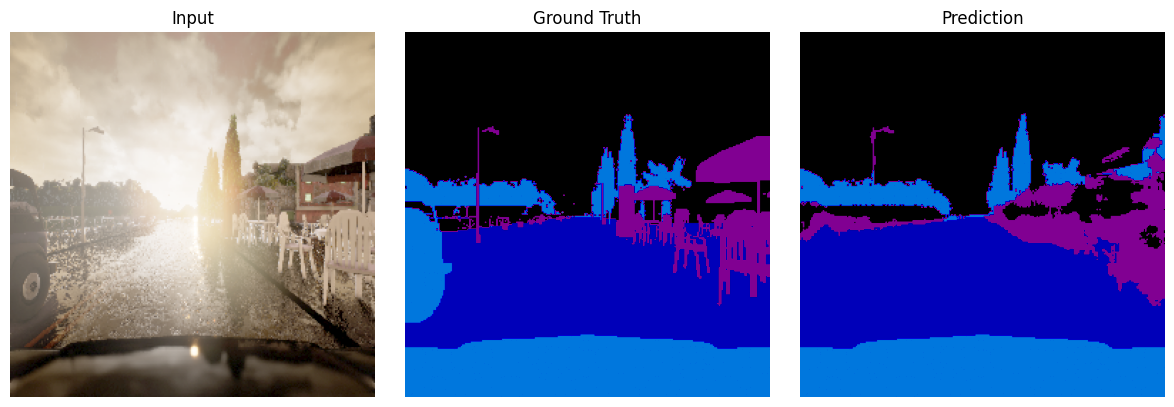

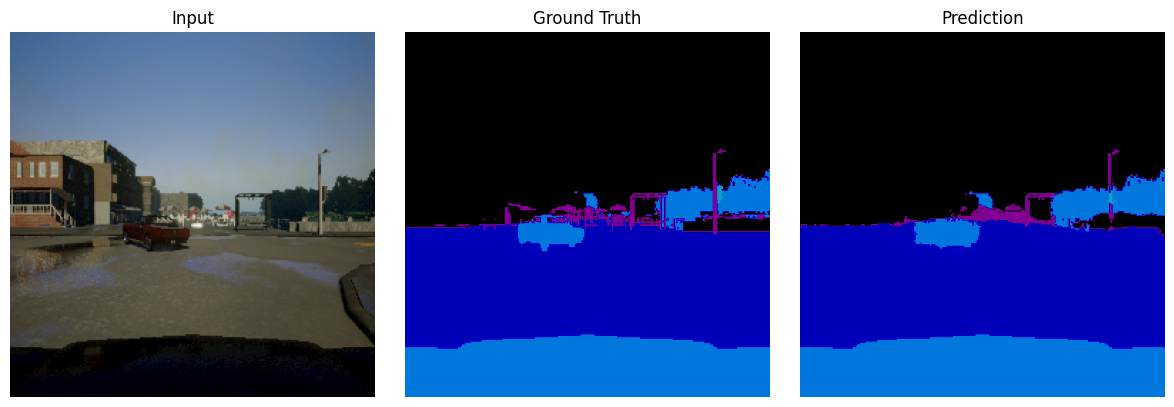

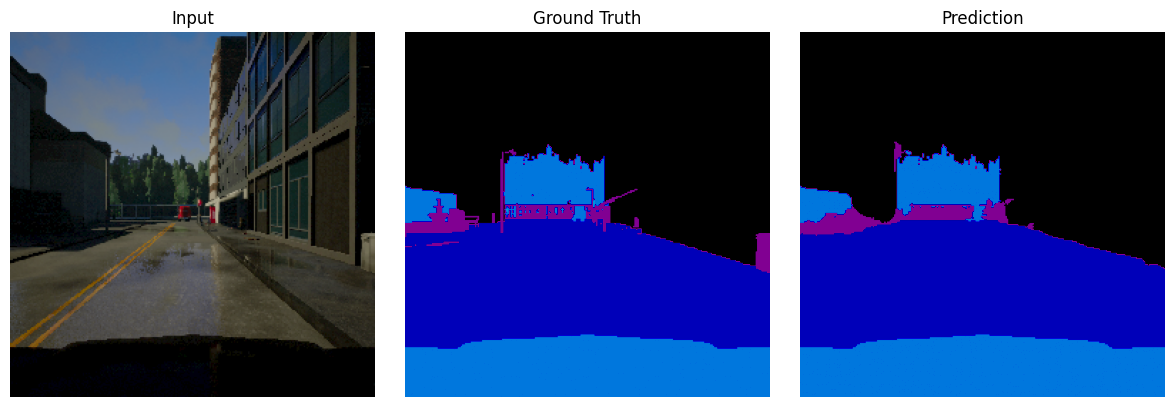

[ResUNet] Test mIoU: 0.8217


In [ ]:
# Train the ResUNet model, compute the training loss, mIoU, plot the training loss and validation mIoU
model_resunet = ResUNet().to(device)
optimizer = torch.optim.Adam(model_resunet.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
train_losses_res = []
val_mious_res = []
for epoch in range(EPOCHS):
    model_resunet.train()
    epoch_loss = 0
    train_metric = MeanIoU(num_classes=13).to(device)
    for images, masks in tqdm(train_loader, desc=f"[ResUNet] Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model_resunet(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_metric.update(preds, masks)
    train_losses_res.append(epoch_loss / len(train_loader))
    model_resunet.eval()
    val_metric = MeanIoU(num_classes=13).to(device)
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model_resunet(images)
            preds = torch.argmax(outputs, dim=1)
            val_metric.update(preds, masks)
    val_miou = val_metric.compute().item()
    val_mious_res.append(val_miou)
    print(f"[ResUNet] Epoch {epoch+1}: Loss={train_losses_res[-1]:.4f}, Val mIoU={val_miou:.4f}")

model_resunet.eval()
with torch.no_grad():
    for i, (img, msk) in enumerate(val_loader):
        if i == 3: break
        img, msk = img.to(device), msk.to(device)
        out = model_resunet(img)
        pred = torch.argmax(out, dim=1)
        visualize_prediction(img[0], msk[0], pred[0])
        
model_resunet.eval()
test_metric = MeanIoU(num_classes=13).to(device)
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model_resunet(images)
        preds = torch.argmax(outputs, dim=1)
        test_metric.update(preds, masks)

test_miou = test_metric.compute().item()
print(f"[ResUNet] Test mIoU: {test_miou:.4f}")

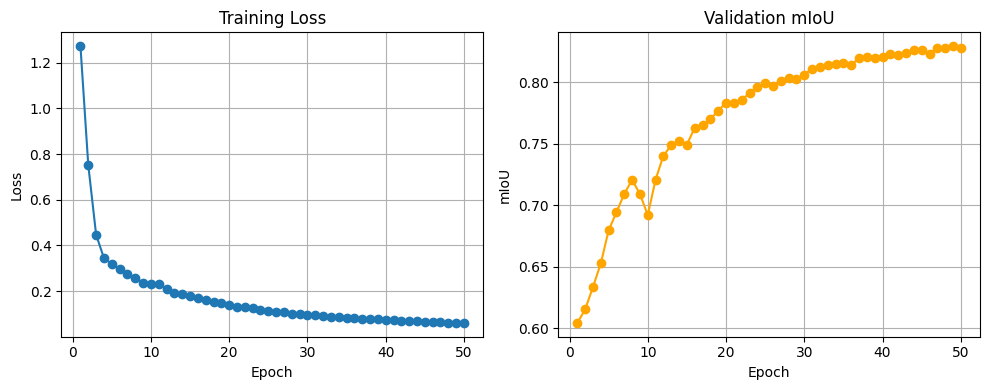

In [15]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses_res) + 1), train_losses_res, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_mious_res) + 1), val_mious_res, marker='o', linestyle='-', color='orange')
plt.xlabel("Epoch")
plt.ylabel("mIoU")
plt.title("Validation mIoU")
plt.grid()
plt.tight_layout()
plt.show()

### Residual U-Net vs. Vanilla U-Net 

#### **Residual U-Net: What Changed?**
In this experiment, the standard convolutional blocks in the U-Net were replaced with **residual blocks**, which add skip connections **within each block**. These internal skip connections help gradient flow and improve learning stability, especially in deeper networks.

---

### **Results Summary**

| Metric                     | Vanilla U-Net     | Residual U-Net      |
|---------------------------|-------------------|----------------------|
| **Best Val mIoU**         | **0.8391**        | 0.8292               |
| **Test mIoU**             | **0.8320**        | 0.8217               |
| **Final Loss (Epoch 50)** | 0.0531            | 0.0614               |
| **Convergence Pattern**   | Smooth & Stable   | Smooth, slightly slower |
| **Computation Speed**     | Faster             | **Slower** |

---

### **Insights & Takeaways**

- **Performance**: Residual U-Net performs nearly as well as the Vanilla U-Net, with only a slight drop (~1% mIoU on test set).
- **Stability**: Residual blocks help stabilize deeper networks and could potentially outperform vanilla U-Net if the network is made deeper.
- **Gradient Flow**: Internal residual skips improve gradient propagation during training, preventing vanishing gradients in deeper blocks.
- **Computational Cost**: Slightly higher due to added 1×1 convolutions and additional additions.

---

### **Conclusion**
Residual U-Net offers a strong alternative to Vanilla U-Net with **comparable performance** and better scalability for deeper models. While Vanilla U-Net slightly edges out in this setup, residual blocks may shine more in **larger** and **more complex** architectures.

# Gated Attention U-Net

In [ ]:
class AttentionGate(nn.Module):
    # class to define the attention gate and compute the attention map
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi  # α = attention map

class AttentionUNet(nn.Module):
    # class to define the Attention UNet model, with 4 down-sampling and 4 up-sampling from the image
    def __init__(self, in_channels=3, out_classes=13):
        super().__init__()
        self.enc1 = ResidualConvBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ResidualConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ResidualConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ResidualConvBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = ResidualConvBlock(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.att4 = AttentionGate(F_g=512, F_l=512, F_int=256)
        self.dec4 = ResidualConvBlock(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.att3 = AttentionGate(F_g=256, F_l=256, F_int=128)
        self.dec3 = ResidualConvBlock(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.att2 = AttentionGate(F_g=128, F_l=128, F_int=64)
        self.dec2 = ResidualConvBlock(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.att1 = AttentionGate(F_g=64, F_l=64, F_int=32)
        self.dec1 = ResidualConvBlock(128, 64)
        self.final = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b = self.bottleneck(self.pool4(e4))
        d4 = self.up4(b)
        e4 = self.att4(d4, e4)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))
        d3 = self.up3(d4)
        e3 = self.att3(d3, e3)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        d2 = self.up2(d3)
        e2 = self.att2(d2, e2)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.up1(d2)
        e1 = self.att1(d1, e1)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        return self.final(d1)

[AttU-Net] Epoch 1/50: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


[Attention U-Net] Epoch 1: Loss=1.2433, Val mIoU=0.4409


[AttU-Net] Epoch 2/50: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


[Attention U-Net] Epoch 2: Loss=0.4647, Val mIoU=0.6529


[AttU-Net] Epoch 3/50: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


[Attention U-Net] Epoch 3: Loss=0.3178, Val mIoU=0.5054


[AttU-Net] Epoch 4/50: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


[Attention U-Net] Epoch 4: Loss=0.2761, Val mIoU=0.6442


[AttU-Net] Epoch 5/50: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


[Attention U-Net] Epoch 5: Loss=0.2617, Val mIoU=0.6091


[AttU-Net] Epoch 6/50: 100%|██████████| 100/100 [00:47<00:00,  2.08it/s]


[Attention U-Net] Epoch 6: Loss=0.2487, Val mIoU=0.6874


[AttU-Net] Epoch 7/50: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


[Attention U-Net] Epoch 7: Loss=0.2353, Val mIoU=0.5430


[AttU-Net] Epoch 8/50: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


[Attention U-Net] Epoch 8: Loss=0.2259, Val mIoU=0.6589


[AttU-Net] Epoch 9/50: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


[Attention U-Net] Epoch 9: Loss=0.2182, Val mIoU=0.7217


[AttU-Net] Epoch 10/50: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


[Attention U-Net] Epoch 10: Loss=0.2083, Val mIoU=0.7066


[AttU-Net] Epoch 11/50: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


[Attention U-Net] Epoch 11: Loss=0.2058, Val mIoU=0.7537


[AttU-Net] Epoch 12/50: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


[Attention U-Net] Epoch 12: Loss=0.1962, Val mIoU=0.6300


[AttU-Net] Epoch 13/50: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


[Attention U-Net] Epoch 13: Loss=0.1921, Val mIoU=0.6152


[AttU-Net] Epoch 14/50: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


[Attention U-Net] Epoch 14: Loss=0.1866, Val mIoU=0.7117


[AttU-Net] Epoch 15/50: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


[Attention U-Net] Epoch 15: Loss=0.1843, Val mIoU=0.5352


[AttU-Net] Epoch 16/50: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


[Attention U-Net] Epoch 16: Loss=0.1749, Val mIoU=0.7313


[AttU-Net] Epoch 17/50: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


[Attention U-Net] Epoch 17: Loss=0.1725, Val mIoU=0.7240


[AttU-Net] Epoch 18/50: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


[Attention U-Net] Epoch 18: Loss=0.1699, Val mIoU=0.7647


[AttU-Net] Epoch 19/50: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


[Attention U-Net] Epoch 19: Loss=0.1664, Val mIoU=0.7465


[AttU-Net] Epoch 20/50: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


[Attention U-Net] Epoch 20: Loss=0.1660, Val mIoU=0.7374


[AttU-Net] Epoch 21/50: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


[Attention U-Net] Epoch 21: Loss=0.1596, Val mIoU=0.6453


[AttU-Net] Epoch 22/50: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


[Attention U-Net] Epoch 22: Loss=0.1566, Val mIoU=0.7589


[AttU-Net] Epoch 23/50: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


[Attention U-Net] Epoch 23: Loss=0.1495, Val mIoU=0.7489


[AttU-Net] Epoch 24/50: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


[Attention U-Net] Epoch 24: Loss=0.1487, Val mIoU=0.7718


[AttU-Net] Epoch 25/50: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


[Attention U-Net] Epoch 25: Loss=0.1431, Val mIoU=0.7767


[AttU-Net] Epoch 26/50: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


[Attention U-Net] Epoch 26: Loss=0.1399, Val mIoU=0.7636


[AttU-Net] Epoch 27/50: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


[Attention U-Net] Epoch 27: Loss=0.1360, Val mIoU=0.7849


[AttU-Net] Epoch 28/50: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


[Attention U-Net] Epoch 28: Loss=0.1395, Val mIoU=0.7526


[AttU-Net] Epoch 29/50: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


[Attention U-Net] Epoch 29: Loss=0.1304, Val mIoU=0.7871


[AttU-Net] Epoch 30/50: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


[Attention U-Net] Epoch 30: Loss=0.1262, Val mIoU=0.7752


[AttU-Net] Epoch 31/50: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


[Attention U-Net] Epoch 31: Loss=0.1238, Val mIoU=0.7532


[AttU-Net] Epoch 32/50: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


[Attention U-Net] Epoch 32: Loss=0.1192, Val mIoU=0.7774


[AttU-Net] Epoch 33/50: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


[Attention U-Net] Epoch 33: Loss=0.1152, Val mIoU=0.7973


[AttU-Net] Epoch 34/50: 100%|██████████| 100/100 [00:47<00:00,  2.08it/s]


[Attention U-Net] Epoch 34: Loss=0.1126, Val mIoU=0.8018


[AttU-Net] Epoch 35/50: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


[Attention U-Net] Epoch 35: Loss=0.1099, Val mIoU=0.7910


[AttU-Net] Epoch 36/50: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


[Attention U-Net] Epoch 36: Loss=0.1075, Val mIoU=0.8021


[AttU-Net] Epoch 37/50: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


[Attention U-Net] Epoch 37: Loss=0.1045, Val mIoU=0.8119


[AttU-Net] Epoch 38/50: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


[Attention U-Net] Epoch 38: Loss=0.0998, Val mIoU=0.7943


[AttU-Net] Epoch 39/50: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


[Attention U-Net] Epoch 39: Loss=0.0966, Val mIoU=0.7473


[AttU-Net] Epoch 40/50: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


[Attention U-Net] Epoch 40: Loss=0.0934, Val mIoU=0.8025


[AttU-Net] Epoch 41/50: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


[Attention U-Net] Epoch 41: Loss=0.0984, Val mIoU=0.8164


[AttU-Net] Epoch 42/50: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


[Attention U-Net] Epoch 42: Loss=0.0897, Val mIoU=0.8107


[AttU-Net] Epoch 43/50: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


[Attention U-Net] Epoch 43: Loss=0.0857, Val mIoU=0.8177


[AttU-Net] Epoch 44/50: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


[Attention U-Net] Epoch 44: Loss=0.0845, Val mIoU=0.8213


[AttU-Net] Epoch 45/50: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


[Attention U-Net] Epoch 45: Loss=0.0803, Val mIoU=0.8004


[AttU-Net] Epoch 46/50: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


[Attention U-Net] Epoch 46: Loss=0.0777, Val mIoU=0.8148


[AttU-Net] Epoch 47/50: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


[Attention U-Net] Epoch 47: Loss=0.0791, Val mIoU=0.8230


[AttU-Net] Epoch 48/50: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


[Attention U-Net] Epoch 48: Loss=0.0778, Val mIoU=0.8273


[AttU-Net] Epoch 49/50: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


[Attention U-Net] Epoch 49: Loss=0.0718, Val mIoU=0.8277


[AttU-Net] Epoch 50/50: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


[Attention U-Net] Epoch 50: Loss=0.0701, Val mIoU=0.8283


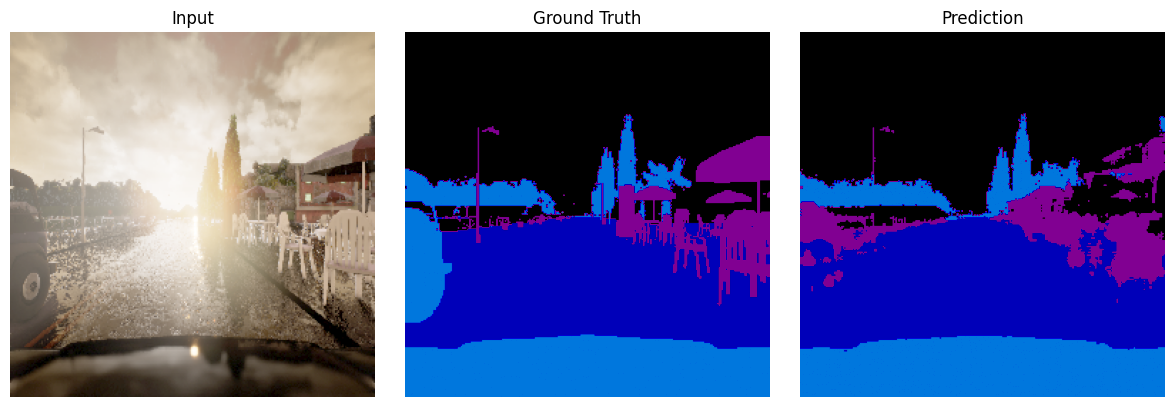

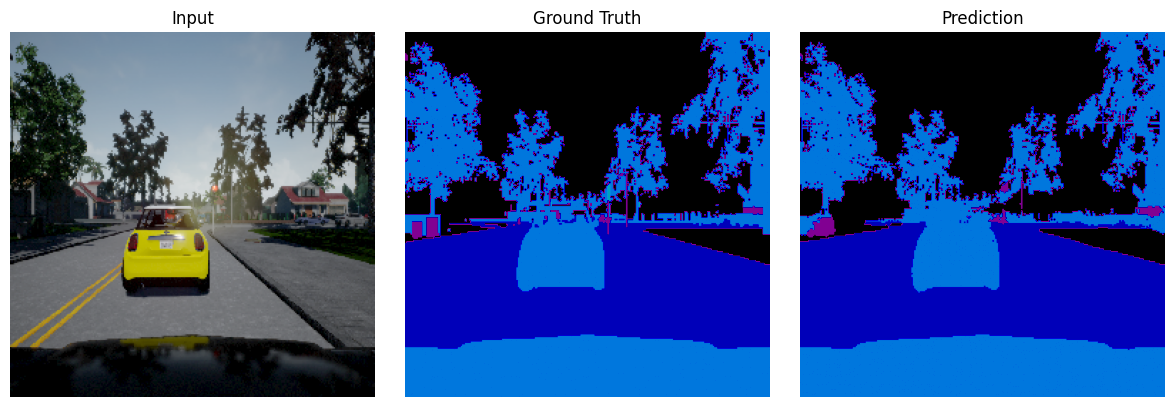

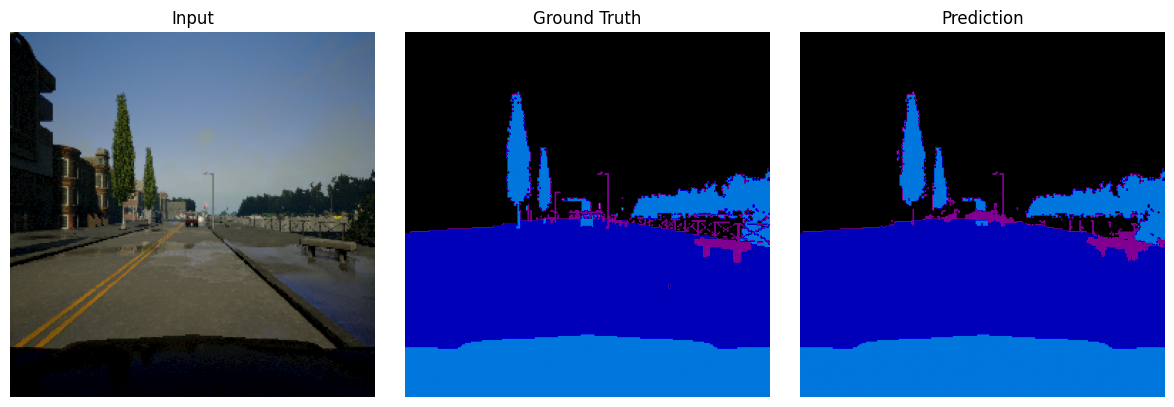

[Attention U-Net] Test mIoU: 0.8206


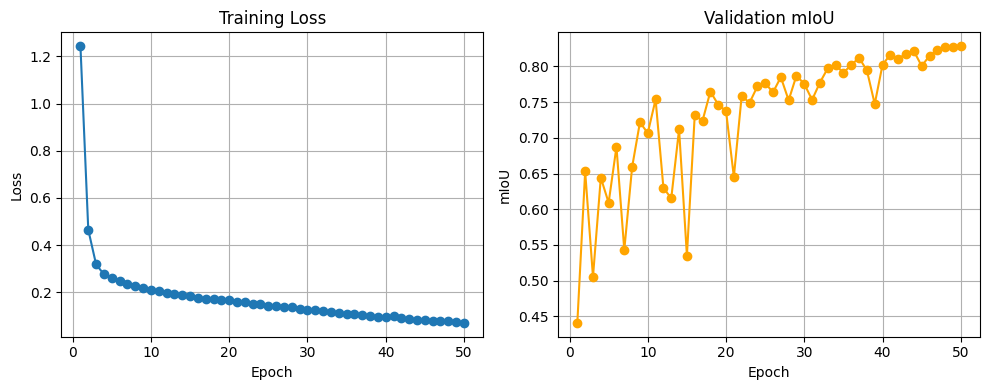

In [ ]:
train_loader = DataLoader(Subset(full_dataset, train_idx), batch_size=15, shuffle=True)
val_loader = DataLoader(Subset(full_dataset, val_idx), batch_size=15, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=15, shuffle=False)

# Train the Attention UNet model, compute the training loss, mIoU, plot the training loss and validation mIoU
model_att = AttentionUNet().to(device)
optimizer = torch.optim.Adam(model_att.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

train_losses_att = []
val_mious_att = []

for epoch in range(EPOCHS):
    model_att.train()
    epoch_loss = 0
    train_metric = MeanIoU(num_classes=13).to(device)

    for images, masks in tqdm(train_loader, desc=f"[AttU-Net] Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model_att(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_metric.update(preds, masks)

    train_losses_att.append(epoch_loss / len(train_loader))

    # Validation
    model_att.eval()
    val_metric = MeanIoU(num_classes=13).to(device)
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model_att(images)
            preds = torch.argmax(outputs, dim=1)
            val_metric.update(preds, masks)

    val_miou = val_metric.compute().item()
    val_mious_att.append(val_miou)
    print(f"[Attention U-Net] Epoch {epoch+1}: Loss={train_losses_att[-1]:.4f}, Val mIoU={val_miou:.4f}")

model_att.eval()
with torch.no_grad():
    for i, (img, msk) in enumerate(val_loader):
        if i == 3: break
        img, msk = img.to(device), msk.to(device)
        out = model_att(img)
        pred = torch.argmax(out, dim=1)
        visualize_prediction(img[0], msk[0], pred[0])
        

# Test mIoU
model_att.eval()
test_metric = MeanIoU(num_classes=13).to(device)
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model_att(images)
        preds = torch.argmax(outputs, dim=1)
        test_metric.update(preds, masks)

test_miou = test_metric.compute().item()
print(f"[Attention U-Net] Test mIoU: {test_miou:.4f}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses_att) + 1), train_losses_att, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_mious_att) + 1), val_mious_att, marker='o', linestyle='-', color='orange')
plt.xlabel("Epoch")
plt.ylabel("mIoU")
plt.title("Validation mIoU")
plt.grid()
plt.tight_layout()
plt.show()

## Attention U-Net: Gated Skip Connections for Improved Segmentation

### 1. What are the advantages of using Attention Gates (AGs)?  
**How does the gating signal at skip connections improve performance?**

According to the paper:

- **Suppression of Irrelevant Regions:**  
  Attention Gates (AGs) allow the model to automatically focus on salient regions (e.g., organs like pancreas, spleen), suppressing irrelevant background features during both **forward** and **backward** passes.

- **Context-Aware Gating:**  
  Gating signals are extracted from coarser layers in the U-Net encoder and used to conditionally weight skip connection features. This ensures that only task-relevant features are forwarded, which reduces false positives.

- **No Extra Supervision or Cascading Needed:**  
  Unlike multi-stage cascaded CNNs that require separate ROI extraction, AGs operate within a single feed-forward U-Net, reducing memory and compute overhead while improving accuracy.

- **Spatial Attention Mechanism (Grid Attention):**  
  Attention is computed per spatial location rather than globally, improving local relevance. It helps highlight small structures like the pancreas, which vary significantly in size and shape.

- **Improved Gradient Flow:**  
  AGs also scale gradients during backpropagation, allowing better updates to encoder layers based on relevant regions only.

---

### 2. Results Comparison: Attention U-Net vs. Vanilla U-Net

#### Final Test Set mIoU Scores:
| Model           | Test mIoU |
|----------------|------------|
| **Vanilla U-Net**   | **0.8320** |
| **Residual U-Net**  | **0.8217** |
| **Attention U-Net** | **0.8206** |

#### Key Observations:

- **Performance Trends:**  
  While all models improve over epochs, **Attention U-Net and Vanilla U-Net converge to similar performance** (~0.83 test mIoU), with Attention U-Net trailing slightly.

- **Stability:**  
  Attention U-Net shows **fluctuations in validation mIoU** across epochs, suggesting sensitivity to initialization or possibly requiring more fine-tuning or larger batch sizes.

- **Faster Boost in Early Epochs:**  
  Attention U-Net shows **rapid mIoU improvement** in early epochs (e.g., from 0.44 to 0.75 by epoch 11), hinting that AGs help in learning salient regions quickly.

- **Residual U-Net slightly outperforms AG-U-Net early**, but AG-U-Net catches up by epoch 50.

- **Visual Clarity (from paper):**  
  Qualitative results in the paper show **sharper boundaries** and **fewer false positives** using AGs, especially useful in small organs like the pancreas.

---

### Summary

| Model         | Feature Enhancement                     | Final Test mIoU | Notes                                                  |
|---------------|------------------------------------------|------------------|--------------------------------------------------------|
| Vanilla U-Net | Basic skip connections                   | 0.8320           | Strong baseline, stable convergence                   |
| Residual U-Net| Residual conv blocks in encoder/decoder  | 0.8217           | Faster convergence, slightly lower final performance  |
| Attention U-Net| Gated skip connections (additive attention)| 0.8206           | Strong early gains, needs more tuning for stability    |
